In [362]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from rhessys import utilities as rh
import hydro.objective_fxns as ofx
import ntpath
from hydro import objective_fxns as ob
from IPython.display import clear_output
import ipyparallel as p
import ProgressBar as pb
from pymail import alert

In [363]:
C = p.Client()

In [364]:
C.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [365]:
view = C.load_balanced_view()

In [366]:
calname = 'et_cal17'
site = 'providence/theo_p301_flux'
m = np.loadtxt('/RHESSys/%s/scripts/%s_m.txt'%(site,calname))
ksat = np.loadtxt('/RHESSys/%s/scripts/%s_ksat.txt'%(site,calname))
gw1 = np.loadtxt('/RHESSys/%s/scripts/%s_gw1.txt'%(site,calname))
#gw2 = np.loadtxt('/RHESSys/%s/scripts/%s_gw2.txt'%(site,calname))
#gsmax = np.loadtxt(prfx+'gsmax.txt')
#sd = np.loadtxt(prfx+'sd.txt')
rd = np.loadtxt('/RHESSys/%s/scripts/%s_rd.txt'%(site,calname))
po = np.loadtxt('/RHESSys/%s/scripts/%s_po.txt'%(site,calname))
pa = np.loadtxt('/RHESSys/%s/scripts/%s_pa.txt'%(site,calname))
#lai = np.loadtxt('/RHESSys/%s/scripts/%s_lai.txt'%(site,calname))
#sd = np.loadtxt('/RHESSys/ComoCreek_new/scripts/%s_sd.txt'%calname)

In [367]:
strt = 2009
nd = 2010

In [368]:
# load ET calibration data
FT = pd.read_pickle('../../../greenness_timing/ameriflux/CA_p301/P301.pcl')
FT['ET'] = FT.tot_ET
FT['wateryear'] = FT.index.map(rh.wateryear)
FT_daily = FT.loc[(FT.wateryear>=strt) & (FT.wateryear<=nd),:]
FT_weekly = FT_daily.resample('W',how=np.sum)
FT_monthly = FT_daily.resample('M',how=np.sum)

In [369]:
# load streamflow calibration data
Q = pd.read_pickle('./data/P301_specific_discharge.pcl')
Q['wateryear'] = Q.index.map(rh.wateryear)
Q_daily = Q.loc[(Q.wateryear>=strt) & (Q.wateryear<=nd),:]
Q_weekly = Q_daily.resample('W',how=np.sum)
Q_monthly = Q_daily.resample('M',how=np.sum)

In [370]:
%%px
import numpy as np
import pandas as pd
from rhessys import utilities as rh
import hydro.objective_fxns as ofx
# set bounds on the data
strt = 2009
nd = 2010
# load ET data
FT = pd.read_pickle('/Volumes/Users/Theo/greenness_timing/ameriflux/CA_p301/P301.pcl')
FT['ET'] = FT.tot_ET # make total ET the ET variable
FT['wateryear'] = FT.index.map(rh.wateryear)
FT_daily = FT.loc[(FT.wateryear>=strt) & (FT.wateryear<=nd),:]
FT_weekly = FT_daily.resample('W',how=np.sum)
FT_monthly = FT_daily.resample('M',how=np.sum)
# load streamflow data
Q = pd.read_pickle('/Volumes/Users/Theo/projects/RHESSys/providence/data/P301_specific_discharge.pcl')
Q['wateryear'] = Q.index.map(rh.wateryear)
Q_daily = Q.loc[(Q.wateryear>=strt) & (Q.wateryear<=nd),:]
Q_weekly = Q_daily.resample('W',how=np.sum)
Q_monthly = Q_daily.resample('M',how=np.sum)

In [372]:
files = glob.glob('/RHESSys/%s/out/%s/*_basin.daily'%(site,calname))

In [373]:
cals = pd.DataFrame({'files':files})

In [375]:
cals.files[0]

'/RHESSys/providence/theo_p301_flux/out/et_cal17/et_cal17_0_basin.daily'

In [376]:
cals.shape

(20000, 1)

In [377]:
def calc_obfx(fl):
    
    # extract idx
    idx = int(fl.split('/')[-1].split('_')[-2])
    
    # load and process the data
    dat = rh.readRHESSysBasin(fl)
    dat_daily = dat.loc[(dat.wateryear>=strt) & (dat.wateryear<=nd),:] # crop by water year
    dat_weekly = dat_daily.resample('W', how= np.sum)
    dat_monthly = dat_daily.resample('M', how= np.sum)
    
    # compute ET metrics
    nse_ET_daily = ofx.nashsut(FT_daily.ET,dat_daily.ET) # daily NSE
    nse_ET_weekly = ofx.nashsut(FT_weekly.ET,dat_weekly.ET) # weekly NSE
    nse_ET_monthly = ofx.nashsut(FT_monthly.ET,dat_monthly.ET) # monthly NSE
    pe_ET_daily = ofx.percenterror (FT_daily.ET,dat_daily.ET) # daily PE
    pe_ET_weekly = ofx.percenterror(FT_weekly.ET,dat_weekly.ET) # weekly PE
    pe_ET_monthly = ofx.percenterror(FT_monthly.ET,dat_monthly.ET) # monthly PE
    
    # compute Streamflow metrics
    nse_SF_daily = ofx.nashsut(Q_daily.discharge,dat_daily.streamflow) # daily NSE
    nse_SF_weekly = ofx.nashsut(Q_weekly.discharge,dat_weekly.streamflow) # weekly NSE
    nse_SF_monthly = ofx.nashsut(Q_monthly.discharge,dat_monthly.streamflow) # monthly NSE
    pe_SF_daily = ofx.percenterror (Q_daily.discharge,dat_daily.streamflow) # daily PE
    pe_SF_weekly = ofx.percenterror(Q_weekly.discharge,dat_weekly.streamflow) # weekly PE
    pe_SF_monthly = ofx.percenterror(Q_monthly.discharge,dat_monthly.streamflow) # monthly PE
    
    nse_et_wt = 0.25
    pe_et_wt = 0.25
    nse_sf_wt = 0.25
    pe_sf_wt = 0.25
    
    
    # compute daily metric
    #daily = np.nanmean(np.array([nse_ET_daily,nse_SF_daily,(1-(pe_ET_daily/100.)),(1-(pe_SF_daily/100.))]))
    
    daily = np.nansum([nse_et_wt*nse_ET_daily,nse_sf_wt*nse_SF_daily,pe_et_wt*(1-(pe_ET_daily/100.)),pe_sf_wt*(1-(pe_SF_daily/100.))])
    
    # compute weekly metric
    #weekly = np.nanmean([nse_ET_weekly,nse_SF_weekly,(1-(pe_ET_weekly/100.)),(1-(pe_SF_weekly/100.))])
        
    weekly = np.nansum([nse_et_wt*nse_ET_weekly,nse_sf_wt*nse_SF_weekly,pe_et_wt*(1-(pe_ET_weekly/100.)),pe_sf_wt*(1-(pe_SF_weekly/100.))])
    
    # compute monthly metric
    #monthly = np.nanmean([nse_ET_monthly,nse_SF_monthly,(1-(pe_ET_monthly/100.)),(1-(pe_SF_monthly/100.))])
    
    monthly = np.nansum([nse_et_wt*nse_ET_monthly,nse_sf_wt*nse_SF_monthly,pe_et_wt*(1-(pe_ET_monthly/100.)),pe_sf_wt*(1-(pe_SF_monthly/100.))])
    
    
    return (idx,nse_ET_daily,nse_ET_weekly,nse_ET_monthly,pe_ET_daily,pe_ET_weekly,pe_ET_monthly,nse_SF_daily,
            nse_SF_weekly,nse_SF_monthly,pe_SF_daily,pe_SF_weekly,pe_SF_monthly,daily,weekly,monthly)

In [378]:
res = view.map(calc_obfx,cals.files)

In [379]:
prog = pb.ProgressBar(len(cals))

In [380]:
import time

In [381]:
while res.ready() == False:
    prog.animate_ipython(res.progress)
    time.sleep(2)

alert.send_alert('barnhatb@colorado.edu','Processing %s has finished'%calname,'Your script has finished')

[****************100%******************]  19938 of 20000 complete


In [382]:
res.ready()

True

In [383]:
idx,nse_ET_daily,nse_ET_weekly,nse_ET_monthly,pe_ET_daily,pe_ET_weekly,pe_ET_monthly,nse_SF_daily,nse_SF_weekly,nse_SF_monthly,pe_SF_daily,pe_SF_weekly,pe_SF_monthly,daily,weekly,monthly = zip(*res.result())

In [384]:
tmp1 = pd.DataFrame({'rd':rd,'lai':lai,'m':m,'ksat':ksat,'po':po,'pa':pa,'gw1':gw1,'idx':np.arange(0,len(cals))})
tmp2 = pd.DataFrame({'idx':idx,'nse_ET_daily':nse_ET_daily,'nse_ET_weekly':nse_ET_weekly,'nse_ET_monthly':nse_ET_monthly,
                     'pe_ET_daily':pe_ET_daily,'pe_ET_weekly':pe_ET_weekly,'pe_ET_monthly':pe_ET_monthly,
                     'nse_SF_daily':nse_SF_daily,'nse_SF_weekly':nse_SF_weekly,'nse_SF_monthly':nse_SF_monthly,
                     'pe_SF_daily':pe_SF_daily,'pe_SF_weekly':pe_SF_weekly,'pe_SF_monthly':pe_SF_monthly,
                     'daily':daily,'weekly':weekly,'monthly':monthly})

df = pd.merge(left=tmp1,right=tmp2,on='idx')

In [385]:
df.to_pickle('./data/%s.pcl'%calname)

In [386]:
var = 'monthly'
idx = df.loc[df[var]==df[var].max()].idx.as_matrix()[0]
#idx = 4683
dat = rut.readRHESSysBasin('/RHESSys/providence/theo_p301_flux/out/%s/%s_%s_basin.daily'%(calname,calname,idx))
dat_daily = dat.loc[(dat.wateryear>=strt)&(dat.wateryear<=nd)]
dat_weekly = dat_daily.resample('W',how=np.nansum)
dat_monthly = dat_daily.resample('M',how=np.nansum)
df.loc[df[var]==df[var].max()]

,gw1,idx,ksat,lai,m,pa,po,rd,daily,monthly,...,nse_SF_daily,nse_SF_monthly,nse_SF_weekly,pe_ET_daily,pe_ET_monthly,pe_ET_weekly,pe_SF_daily,pe_SF_monthly,pe_SF_weekly,weekly
12172,0.442,12172,505.26,0.63,3.137,0.4658,2.5329,8.503,-4.564874,0.790281,...,-2.59112,0.575533,0.173256,53.13284,1.261054,2.562295,1.972214,1.144097,1.442404,0.711928


In [387]:
for key in df.loc[df[var]==df[var].max()].columns:
    print '%s: %s'%(key,df.loc[df[var]==df[var].max()][key].as_matrix()[0])

gw1: 0.442
idx: 12172
ksat: 505.26
lai: 0.63
m: 3.137
pa: 0.4658
po: 2.5329
rd: 8.503
daily: -4.56487398296
monthly: 0.790281257365
nse_ET_daily: -17.1173250928
nse_ET_monthly: 0.609643145196
nse_ET_weekly: 0.714501472217
nse_SF_daily: -2.59112030489
nse_SF_monthly: 0.575533390969
nse_SF_weekly: 0.173255941524
pe_ET_daily: 53.1328395513
pe_ET_monthly: 1.26105376832
pe_ET_weekly: 2.56229487234
pe_SF_daily: 1.97221386529
pe_SF_monthly: 1.14409690229
pe_SF_weekly: 1.44240365316
weekly: 0.711927607121


In [388]:
calname

'et_cal17'

In [389]:
df.describe()

,gw1,idx,ksat,lai,m,pa,po,rd,daily,monthly,...,nse_SF_daily,nse_SF_monthly,nse_SF_weekly,pe_ET_daily,pe_ET_monthly,pe_ET_weekly,pe_SF_daily,pe_SF_monthly,pe_SF_weekly,weekly
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.749215,9999.500000,299.910173,0.904658,9.973337,1.211603,1.881878,6.015634,-5.761206,-0.210097,...,-4.507599,-1.666170,-2.159870,45.695781,1.593726,3.059545,1.165170,1.084892,1.122058,-0.303601
std,0.429253,5773.647028,172.735933,0.409060,5.754011,0.698974,1.096087,2.307898,8.569075,0.572169,...,23.746794,2.161562,4.502184,26.222528,0.669712,0.906208,0.727060,0.443793,0.562869,1.094835
min,0.010000,0.000000,1.010000,0.200000,0.010000,0.001200,0.001000,2.000000,-199.919344,-8.126233,...,-760.783617,-34.501903,-164.090710,14.634791,0.761992,1.810008,0.594614,0.499735,0.528810,-40.440468
25%,0.379000,4999.750000,149.592500,0.550000,5.023000,0.602775,0.937200,3.994750,-9.502895,-0.245645,...,-1.017260,-0.962922,-0.858646,19.102782,1.067387,2.359795,1.000000,1.000000,1.000000,-0.166636
50%,0.743000,9999.500000,301.565000,0.910000,10.002500,1.212050,1.880300,6.032000,-3.289235,-0.059648,...,-0.839167,-0.962922,-0.858646,45.615522,1.307134,2.711621,1.000000,1.000000,1.000000,-0.120923
75%,1.120000,14999.250000,449.580000,1.260000,14.924500,1.817825,2.826500,8.003000,0.022088,0.065957,...,-0.839167,-0.962922,-0.858646,66.527104,2.068409,3.708014,1.039279,1.000000,1.016768,0.066498
max,1.499000,19999.000000,599.980000,1.610000,19.999000,2.419800,3.799800,9.999000,0.356429,0.790281,...,0.346859,0.660346,0.362488,104.814496,3.441346,5.425152,13.744209,9.267183,11.334358,0.744685


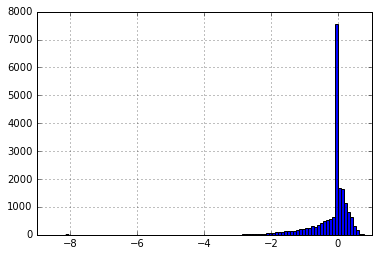

In [390]:
df.monthly.hist(bins=100)

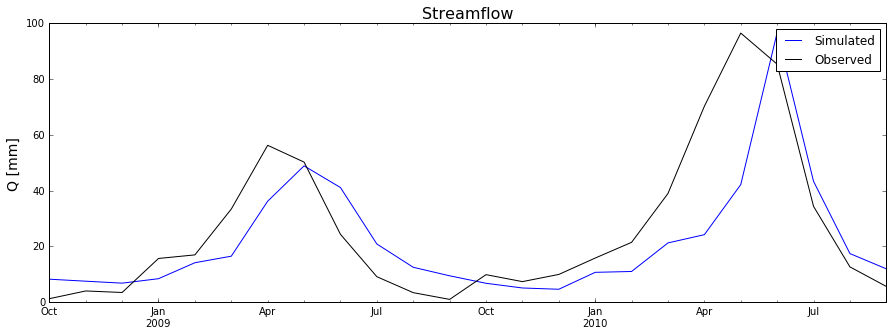

In [391]:
plt.figure(figsize=(15,5))
dat_monthly.streamflow.plot(label='Simulated', c= 'b')
Q_monthly.discharge.plot(label='Observed', c = 'k')
plt.legend()
plt.title('Streamflow', fontsize=16)
plt.ylabel('Q [mm]', fontsize=14)

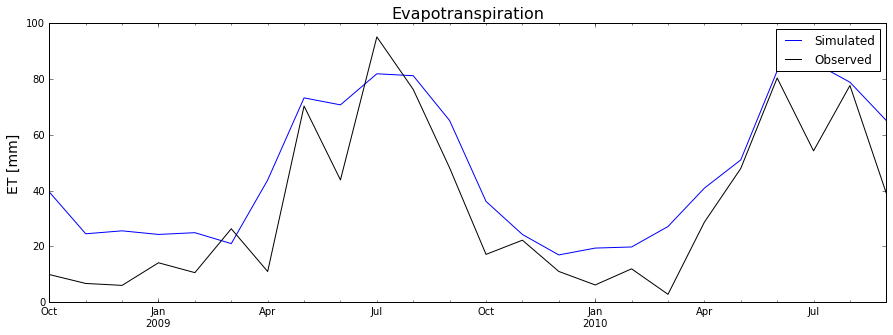

In [392]:
plt.figure(figsize=(15,5))
dat_monthly.ET.plot(label='Simulated', c = 'b')
FT_monthly.ET.plot(label='Observed', c = 'k')
plt.legend()
plt.title('Evapotranspiration', fontsize=16)
plt.ylabel('ET [mm]', fontsize=14)

(0, 4)

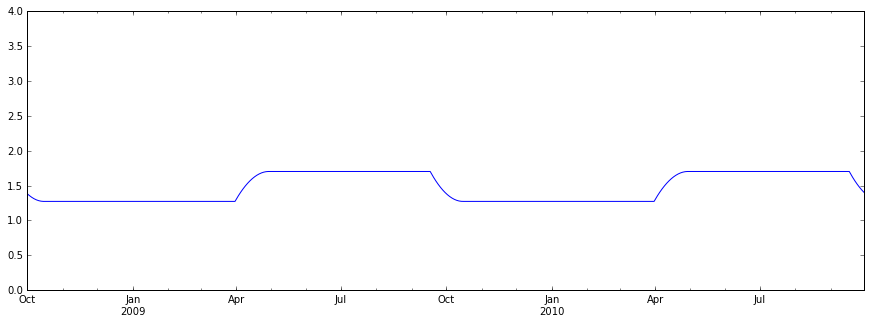

In [393]:
plt.figure(figsize=(15,5))
dat_daily['lai'].plot()
plt.ylim(0,4)